<h1>Swedish Leaf Classification<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Globals" data-toc-modified-id="Imports-and-Globals-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Globals</a></span></li><li><span><a href="#Choose-Leaves-for-Classification" data-toc-modified-id="Choose-Leaves-for-Classification-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Choose Leaves for Classification</a></span><ul class="toc-item"><li><span><a href="#Visualize-Images" data-toc-modified-id="Visualize-Images-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Visualize Images</a></span></li><li><span><a href="#Analyze-Leaves-Similarity-Using-PCA" data-toc-modified-id="Analyze-Leaves-Similarity-Using-PCA-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Analyze Leaves Similarity Using PCA</a></span></li><li><span><a href="#Determine-Leaves-for-classification" data-toc-modified-id="Determine-Leaves-for-classification-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Determine Leaves for classification</a></span></li></ul></li><li><span><a href="#Define-Datasets-and-Evaluation-Metrics-for-Task" data-toc-modified-id="Define-Datasets-and-Evaluation-Metrics-for-Task-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define Datasets and Evaluation Metrics for Task</a></span></li><li><span><a href="#Baseline:-Logistic-Regression" data-toc-modified-id="Baseline:-Logistic-Regression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Baseline: Logistic Regression</a></span><ul class="toc-item"><li><span><a href="#PCA-Again:-Dimensionality-Reduction" data-toc-modified-id="PCA-Again:-Dimensionality-Reduction-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>PCA Again: Dimensionality Reduction</a></span></li><li><span><a href="#Baseline-Algorithm:" data-toc-modified-id="Baseline-Algorithm:-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Baseline Algorithm:</a></span></li><li><span><a href="#Train-Validation-Split" data-toc-modified-id="Train-Validation-Split-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Train-Validation Split</a></span></li><li><span><a href="#Train-and-Evaluate" data-toc-modified-id="Train-and-Evaluate-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Train and Evaluate</a></span></li></ul></li><li><span><a href="#Transfer-Learning-Model" data-toc-modified-id="Transfer-Learning-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Transfer Learning Model</a></span><ul class="toc-item"><li><span><a href="#Convert-Data-to-PyTorch-Format" data-toc-modified-id="Convert-Data-to-PyTorch-Format-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Convert Data to PyTorch Format</a></span></li><li><span><a href="#Net-Architecture" data-toc-modified-id="Net-Architecture-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Net Architecture</a></span></li><li><span><a href="#Define-Training-Scheme" data-toc-modified-id="Define-Training-Scheme-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Define Training Scheme</a></span></li><li><span><a href="#ResNet-as-a-Feature-Extraction-Model" data-toc-modified-id="ResNet-as-a-Feature-Extraction-Model-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>ResNet as a Feature Extraction Model</a></span></li></ul></li><li><span><a href="#Increase-the-Challenge:-Classify-Similar-Leaves" data-toc-modified-id="Increase-the-Challenge:-Classify-Similar-Leaves-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Increase the Challenge: Classify Similar Leaves</a></span><ul class="toc-item"><li><span><a href="#Baseline" data-toc-modified-id="Baseline-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#Transfer-Learning-ResNet" data-toc-modified-id="Transfer-Learning-ResNet-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Transfer Learning ResNet</a></span><ul class="toc-item"><li><span><a href="#Fine-Tune-the-Net-for-Improving-Results" data-toc-modified-id="Fine-Tune-the-Net-for-Improving-Results-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Fine Tune the Net for Improving Results</a></span></li></ul></li></ul></li><li><span><a href="#Model-Explainability" data-toc-modified-id="Model-Explainability-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Model Explainability</a></span></li><li><span><a href="#Conclusion-and-Future-Work" data-toc-modified-id="Conclusion-and-Future-Work-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusion and Future Work</a></span></li><li><span><a href="#Sources" data-toc-modified-id="Sources-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Sources</a></span></li></ul></div>

In this notebook I will propose a binary classifier for predicting a tree class based on its leaf image.

For training the model and evaluate it I will use the [swedish leaf dataset](https://www.cvl.isy.liu.se/en/research/datasets/swedish-leaf/).
This dataset contains leafs from 15 different trees, and I will choose two of them for defining the task.

The method for building the classifier will be transfer leaning: I will download a pretrained multiclassification model, 
trained on imagenet dataset, and will modify it to a binary classifier.

To evaluate the proposed model, I will train a baseline model for the same task. Both models will be given an Accuracy score on the same test set, and their performance will be evaluated by this score. This score is simple and useful when the data for classification is balanced across different classes, which is the case for the leaf dataset.

Finally, I will look at some images from the test set and will try to explain their model classifications.

# Imports and Globals

In [2]:
# Python built-in
import os
from copy import deepcopy
from time import time
from typing import Tuple, Dict, Union, List, Iterator

# Data analysis and Manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2 as cv

# sklearn
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import joblib # save sklearn objects

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.parameter import Parameter
from torchvision import transforms, models

# Explainability
from captum.attr import GradientShap
from captum.attr import visualization as viz

# Turn off warnings for better readability
import warnings
warnings.filterwarnings("ignore")

# CUDA configuration if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for PyTorch')

Using cuda for PyTorch


In [3]:
# Useful Paths
PROJECT_DIR = (os.path.join(os.path.expanduser("~"),"swedish-leaf-classification"))
DATA_PATH = os.path.join(PROJECT_DIR, "swedish-leaf-dataset")
MODEL_PATH = os.path.join(PROJECT_DIR, "models")

# Classes
TREE_NAMES = [
    "Ulmus carpinifolia",
    "Acer",
    "Salix aurita",
    "Quercus",
    "Alnus incana",
    "Betula pubescens",
    "Salix alba 'Sericea'",
    "Populus tremula",
    "Ulmus glabra",
    "Sorbus aucuparia",
    "Salix sinerea",
    "Populus",
    "Tilia",
    "Sorbus intermedia",
    "Fagus silvatica"
]

# Data has same size of images for each class
CLASS_SIZE = 75

# Useful for keeping the test size class-balanced: train-test partition will be ~ 85%-15%
CLASS_TEST_SIZE = 12

The images in the dataset differ in their size, but most of the models expect to get images with same shape. Therefore, I will set a global height and width for an image. 224x224 is the minimal size that a pretrained model in PyTorch can get.

In [5]:
IMAGE_HEIGHT = IMAGE_WIDTH = 224

In [6]:
def load_image(filename: str, height: int = IMAGE_HEIGHT, width: int = IMAGE_WIDTH) -> np.ndarray:
    """
Loads an image from filename to a format that can be utilized for the classification task.
    :param filename:  path to image
    :param height: height size of output
    :param width: width size of output
    :return: array of image with shapes (height, width, 3). The last axis represents the RGB colors of the image.
    """
    image = cv.imread(filename, cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (height, width))
    return image


def load_leaf_class(leaf_folder: str, label: int) -> Tuple[np.ndarray, np.ndarray]:
    """
Loads all images of a given leaf folder.
    :param leaf_folder: path to leaf folder
    :param label: the class label to assign for this leaf images.
    :return: tuple of the images array and their corresponding labels.
    """
    leaf_path = os.path.join(DATAPATH, leaf_folder)
    leaf_images_list = []

    for filename in os.listdir(leaf_path):
        leaf_images_list.append(load_image(os.path.join(leaf_path, filename)))

    data = np.stack(leaf_images_list)
    label_arr = np.repeat(label, len(leaf_images_list)).reshape(-1, 1)
    return data, label_arr


def load_swedish_leaf_dataset() -> Dict[str, Dict[str, np.ndarray]]:
    """
Loads the Swedish Leaf Dataset. The data should be order in disk
    :return: Dict where keys are tree names. Each of them contains an inner Dict with 'X' and 'y'
    keys corresponds to the tree data.
    """
    data = {}
    for i in range(1,len(TREE_NAMES)+1):    # tree classes in formal documentation are from 1 and not from 0
        tree_name = TREE_NAMES[i-1]
        data[tree_name] = {}
        data[tree_name]["X"], data[tree_name]["y"] = load_leaf_class(f"leaf{i}", i)

    return data

In [7]:
tree_data = load_swedish_leaf_dataset()

# Choose Leaves for Classification
We have to choose 2 leaves out of 15 for the classification task.

## Visualize Images
First, let's see some of the different leaves in the data.

1 Sample of Leaf Images:


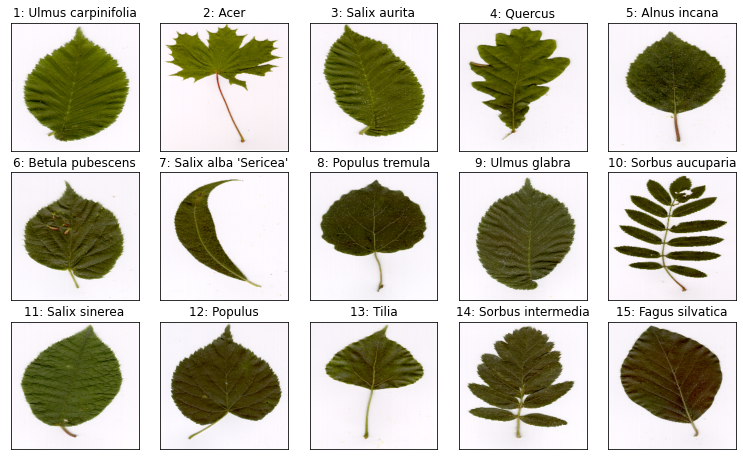

2 Sample of Leaf Images:


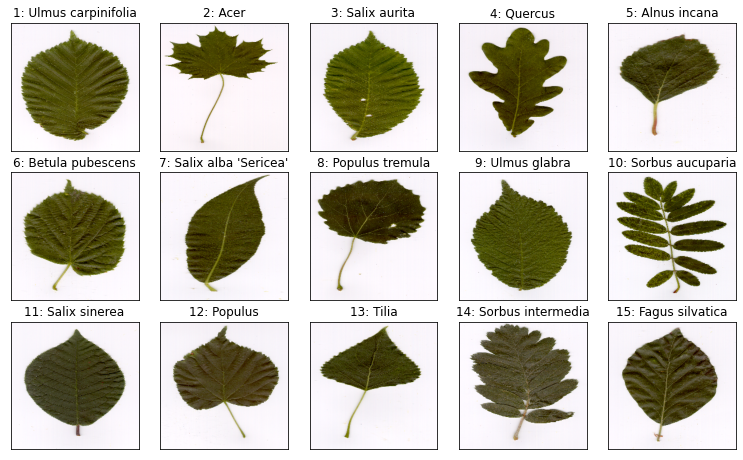

3 Sample of Leaf Images:


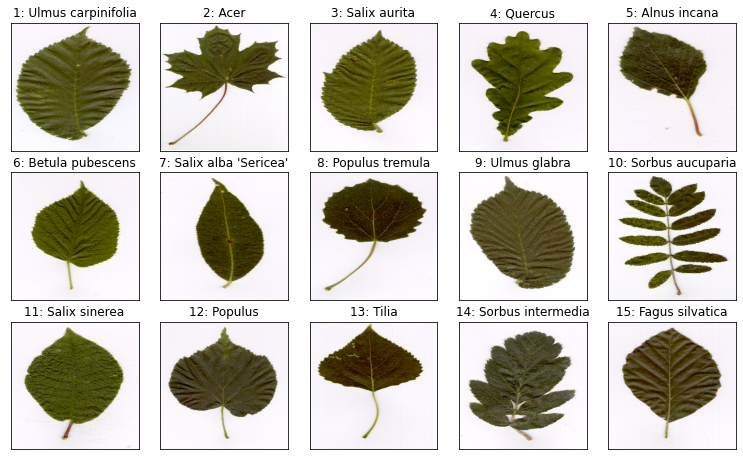

In [8]:
def plot_grid_of_random_leaves(tree_data: Dict[str, Dict[str, np.ndarray]]) -> None:
    """
Plots a grid of one leaf per tree. Leaves are chosen randomly.
    :param tree_data: data contains the Swedish Leaf Dataset (as returned by "load_swedish_leaf_dataset" function)
    """
    fig = plt.figure(figsize=(13, 20))
    grid = ImageGrid(fig, 111, nrows_ncols=(3, 5), axes_pad=0.3, share_all=True)

    # remove axis ticks
    grid[0].get_xaxis().set_ticks([])
    grid[0].get_yaxis().set_ticks([])
    
    # sample an index for choosing the leaves to plot
    idx = np.random.randint(CLASS_SIZE)

    for i, ax in enumerate(grid):
        image = tree_data[TREE_NAMES[i]]["X"][idx, ...]
        ax.imshow(image)
        ax.set_title(f"{i + 1}: {TREE_NAMES[i]}")

    plt.show()

num_of_samples = 3
for i in range(num_of_samples):
    print(f"{i+1} Sample of Leaf Images:")
    plot_grid_of_random_leaves(tree_data)

We can assume that classifying similar leaves will be a more difficult task than classifying dissimilar ones. Broadly speaking, we can see that there is some similar leaves, like 1, 3, 9 and 11. We can also see that 10, 2 and 4 look quite different from every other leaf.

## Analyze Leaves Similarity Using PCA
PCA can be another way of examining the leaves' similarities. We can embed the images in two-dimensional space and see how close the tree classes are to each other. The embeddings can be achieved using PCA. There could be some caveats for using PCA to create such image embeddings, one of them could be that PCA doesn't capture non-linear similarities which probably exist in images. However, PCA is still able to express a large amount of the data variation, while extremely reducing its dimension (and therefore we will use this simple method later in the baseline model). All in all, we have to combine these embeddings with our manual exploration of the leaves images above.

In [9]:
# Gather the whole dataset into X and y arrays
X = np.vstack([tree_data[k]['X'] for k in tree_data.keys()])
y = np.vstack([tree_data[k]['y'] for k in tree_data.keys()])

For applying PCA, we have to convert the images to vectors. We will flatten each of them by collapsing the height, width and color dimension. Also, we will apply standardization to the data for gaining the best possible PCA results. After the PCA calculation, we will average the Principal Components (denoted as "PC's") across classes, and will plot the classes embeddings in the 2-dimensional space (with error bars for standard error of their means).

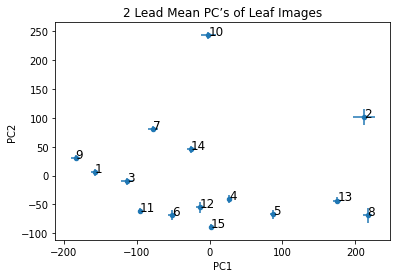

In [10]:
# custom flat-image transform and its inverse transform
def flat_images(x):
    return x.reshape(len(x),-1)

def inverse_flat_images(x, height=IMAGE_HEIGHT, width=IMAGE_WIDTH, channels=3):
    return x.reshape(len(x), height, width, channels)


# Define a Pipline for transformer that apply PCA for images
pca_pipe = Pipeline(steps=[("flat", FunctionTransformer(flat_images, inverse_flat_images)), 
                       ("scaler", StandardScaler()), 
                       ("pca", PCA(n_components=2)), 
                      ])

# aggregate PCA results
df_pca = pd.DataFrame(pca_pipe.fit_transform(X), columns=[f"PC{i}" for i in range(1,pca_pipe['pca'].n_components+1)])
df_pca["class"] = y
df_means_pca = df_pca.groupby('class').agg('mean')
df_sem_pca = df_pca.groupby('class').agg('sem')


# plot mean lead PC's of classes
fig, ax = plt.subplots()

df_means_pca.plot.scatter(*df_means_pca.columns, ax=ax, title="2 Lead Mean PC’s of Leaf Images")
ax.errorbar(df_means_pca['PC1'], df_means_pca['PC2'], df_sem_pca['PC1'], df_sem_pca['PC2'], fmt='none')

for i in df_means_pca.index: # annotate classes by their leaf number
    ax.annotate(str(i), df_means_pca.loc[i].tolist(), size=12)

plt.show()

Part of the insights we have mentioned above can be confirmed by this plot: we can see that the dots of 9, 1, 3 and 11 are close to each other, and that 10 and 2 are more distant.

If we want to give an interpretation for these 2 PC's axis, we could suggest that the first PC is about the inner texture of the leaf: 1, 9 and 3, which have a low PC1 value, have many intense "veins" from the spine of the leaf toward the boundary, while 8 and 2, which have high PC1 value, have sparse ones. We can also suggest that the second PC is about the leaf's boundaries openness: 15, which has a PC2 value, have a slightly smooth boundary compared to other leaves, while 10, which have a high PC2 value, is super open-boundary as it has tiny "sub-leaves" that are not connected.

## Determine Leaves for classification
For the first step, we will pick leaves 10 and 11 as they look dissimilar, thus making the classification task easier.

In [11]:
LEAF1, LEAF2 = 10, 11

# store class names for later analysis, and encode their labels as 0 and 1.
label_name_dict = {0: {'leaf_num':LEAF1, 'name':TREE_NAMES[LEAF1-1]},
                   1: {'leaf_num':LEAF2, 'name':TREE_NAMES[LEAF2-1]},
                  }

# Define Datasets and Evaluation Metrics for Task
The models will be trained by a Binary Cross Entropy loss and will be optimized in the validation phase by this metric. The models will be evaluated by an Accuracy score on test set. This score for classification is intuitive (percentage of images classified correctly) and appropriate when the dataset is class-balanced like the leaf dataset.

In [12]:
def get_train_and_test(tree_data: Dict[str, Dict[str, np.ndarray]], 
                       label_name_dict: Dict[int, Dict[str, Union[int,str]]]
                      ) -> Tuple[np.ndarray,np.ndarray,np.ndarray,np.ndarray]:
    """
Outputs train and test sets from the swedish leaf data.
    :param tree_data: Dict contains the dataset (output of "load_swedish_leaf_dataset" function)
    :param label_name_dict: Dict which his keys are 0 and 1 integers,
    and their values are also Dict with 'leaf_num' and 'name' keys.
    :return: tuple of X_train, y_train, X_test, y_test. X's are of shape (train/test size, height, width, channel)
    and y's are of shape (train/test size, 1).
    """
    X1, X2,  = [tree_data[label_name_dict[label]['name']]['X'] for label in [0, 1]]
    y1, y2 = [np.full((CLASS_SIZE, 1), label) for label in [0, 1]]

    # split data such that both train and test will have class balance 
    splits = [train_test_split(
        data, label, test_size=CLASS_TEST_SIZE, random_state=42)
              for data, label in [(X1, y1), (X2, y2)]]
    X_train, X_test, y_train, y_test = [np.vstack(phase) for phase in zip(*splits)]
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_train_and_test(tree_data, label_name_dict)

# print shapes
print(*(f"{arr_name} shape: {arr.shape}" for arr_name, arr in 
        zip(["X_train", "X_test", "y_train", "y_test"], [X_train, X_test, y_train, y_test])), 
      sep="\n")

X_train shape: (126, 224, 224, 3)
X_test shape: (24, 224, 224, 3)
y_train shape: (126, 1)
y_test shape: (24, 1)


# Baseline: Logistic Regression
Broadly speaking, deep learning models are less preferable method when they achieve the same performance as simple Machine Learning techniques. 

There could be a bunch of reasons for that: ML could be trained on lesser training data and often takes less time to train. Also, it could be trained on CPU, while DL model usually requires GPU. Usually, ML models are simpler in terms of the number of hyperparameters that have to be tuned for a specific model. In addition, a lot of Machine learning algorithms can supply an an interpretable output that could explain the model's decision.

Therefore, it may be useful to come up with a simple ML solution as a baseline for this classification task. With that baseline, we would be able to evaluate the improvement of the DL model, and to examine its necessity.

## PCA Again: Dimensionality Reduction
Logistic Regression input is a table of n rows and p columns, which consists p features for n data observations. As a feature extraction we will use the PCA again, for the reasons stated above in part 2.2. However, this time we are not constrained to output only 2 PC's, but are able to explore any range from 1 PC to the number of training samples PC's. However, we have to be careful not to fall to the 'Curse of dimensionality', which may lead to an unwanted overfitted and unstable model.

We can observe the power of the PCA as a dimensionality reduction method in the two plots below: The first one shows the explained variance ratio for each PC, ordered by their singular values (i.e. the amount of variance that this PC explains). The second one shows the overall explained variance percentage as we add more PC's to the data.

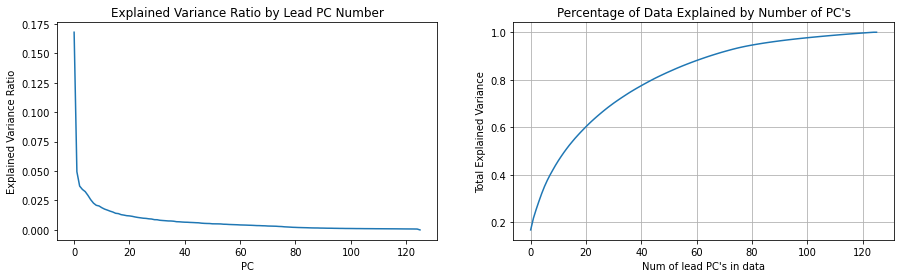

In [13]:
# Extract the maximum availabe PC's from training data
pca_pipe['pca'].set_params(**{'n_components':len(X_train)})
pca_pipe.fit(X_train)

# plot
var_ratios = pca_pipe['pca'].explained_variance_ratio_
fig, axs = plt.subplots(1, 2, figsize=(15,4))

axs[0].plot(var_ratios)
axs[0].set_xlabel("PC")
axs[0].set_ylabel("Explained Variance Ratio")
axs[0].set_title("Explained Variance Ratio by Lead PC Number")

axs[1].plot(np.cumsum(var_ratios))
axs[1].set_xlabel("Num of lead PC's in data")
axs[1].set_ylabel("Total Explained Variance")
axs[1].set_title("Percentage of Data Explained by Number of PC's")
axs[1].grid()

plt.show()

40 PC's can explain nearly 80% of the variance of the data. This is impressive if we consider the original amount of pixels which is $224*224*3 = 150528$. Yet, we have to remember that the PCA is limited in its ability to decrobe non-linear relationships in the data.

## Baseline Algorithm:
1. Flatten image data to a long vector.
2. Standardize data by subtracting the mean and divide by std.
3. Find the k leading PC's.
4. Train a Ridge Logistic Regression with a regularization constant of C (L2 regularization), and with a Binary Cross-Entropy loss as an objective.

In [14]:
log_reg_pipe = Pipeline(steps=[("flat", FunctionTransformer(flat_images, inverse_flat_images)),
                       ("scaler", StandardScaler()), 
                       ("pca", PCA()), 
                       ("log_reg", LogisticRegression(random_state=42))
                      ])

## Train-Validation Split
Notice that the algorithm mentioned above implies setting 2 hyperparameters: k leading PC's and C L2 regularization. We will use a validation set to find the optimal hyperparameters. As the data is relatively small, we will utilize the Cross Validation scheme with 6-folds (which will lead to approximately 70%-15%-15% for train-validation-test split).

The chosen model will be the one that minimizes the validation loss.

In [15]:
K_FOLDS = 6

# Define a search space for hyperparamters
param_grid = {
    "pca__n_components": np.ceil(np.logspace(
        start=2, stop=np.log2(len(X_train) * (K_FOLDS-1)/K_FOLDS), base=2, num=3)).astype(int),
    "log_reg__C": np.logspace(start=-5, stop=1, base=10, num=3),
}

baseline_trainer = GridSearchCV(log_reg_pipe, param_grid, cv=K_FOLDS, verbose=1, 
                      scoring=["neg_log_loss","accuracy"], refit="neg_log_loss")

## Train and Evaluate

In [16]:
baseline_trainer.fit(X_train, y_train.reshape(-1,))
model = baseline_trainer.best_estimator_

# save model
joblib.dump(model, os.path.join(MODEL_PATH, f'baseline_model_leaves_{LEAF1}_{LEAF2}.pkl'), compress=1)

# print chosen model hyperparams
print(f"Best Hyperparameters: {baseline_trainer.best_params_}")
print(f"Acc of Best CV: {baseline_trainer.cv_results_['mean_test_accuracy'][baseline_trainer.best_index_]:.4f}")

Fitting 6 folds for each of 9 candidates, totalling 54 fits
Best Hyperparameters: {'log_reg__C': 10.0, 'pca__n_components': 4}
Acc of Best CV: 1.0000


In [17]:
def evaluate_baseline(model, X, y):
    preds = model.predict(X).reshape(-1,1)
    return classification_report(y, preds)

print(f"Train Scores", "\n", evaluate_baseline(model, X_train, y_train), "\n")
print(f"Test Scores", "\n", evaluate_baseline(model, X_test, y_test), "\n")

Train Scores 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00        63

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126
 

Test Scores 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.92      0.96        12

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24
 



We can see that baseline model Accuracy is <b>0.96</b>

# Transfer Learning Model
In transfer learning we rely on a pretrained model, which has been already trained on a large dataset for other task (e.g. ImageNet for classify 1000 classes), and then use this model as a fixed feature extractor or as a weight initialization for another task. In this section we will train a ConvNet classifier based on a pretrained ResNet. We will modify the net such that its last layer will be a sigmoid binary classifier.

## Convert Data to PyTorch Format

In [18]:
class LeafDataset(Dataset):
    """
    Class for obtaining the Swedish Leaf Dataset.
    """
    def __init__(self, images: np.ndarray, labels: np.ndarray):
        self.images = images
        self.labels = torch.Tensor(labels)
        self.preprocess = self.get_trasforms()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.preprocess(self.images[idx])
        label = self.labels[idx]
        return image, label

    @staticmethod
    def get_trasforms():
        """
    Preprocess pipeline for converting numpy image to an input for pytorch model.
    Image is converted to a tensor and normalized.
        """
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

def split_datasets_evenly(datasets: List[Dataset], valid_size: int) -> Tuple[Dataset, Dataset]:
    """
Makes train and test datasets from a list of datasets. 
Each of the input datasets contains the same class for classification. 
Useful for keeping the data balanced after splitting. 
    :param datasets: the class datasets
    :param valid_size: number of examples to randomly assign for validation set.
    :return: train and test sets.
    """
    splits = [torch.utils.data.random_split(
        data, lengths=(len(data)-valid_size, valid_size))
        for data in datasets]

    train = torch.utils.data.ConcatDataset([split[0] for split in splits])
    test = torch.utils.data.ConcatDataset([split[1] for split in splits])
    return train, test

## Net Architecture
This net transferred a pretrained ResNet into a binary classifier. It has a "freeze" option which determines if the net will serve as a fixed feature extractor or as weight initialization for fine tuning.

In [19]:
class TransferredResNet(torch.nn.Module):
    """
    Uses Pretrained ResNet as early layers and outputs a binary output (e.g. value between 0 and 1) to an input image.
    Can be used as a fixed feature extractor (freeze=True) and also can be fine tuned (freeze=False).
    """
    def __init__(self, freeze: bool):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        if freeze:
            self.__freeze_resnet()
        self.is_freeze = freeze
        last_fc_in_features = self.resnet.fc.in_features
        # define the new task-tailored layer
        self.resnet.fc = torch.nn.Sequential(torch.nn.Linear(last_fc_in_features, 1), torch.nn.Sigmoid())

    def __freeze_resnet(self):
        self.resnet.eval() # ignore dropouts and don't update batchnorm layers
        for param in self.resnet.parameters():
            param.requires_grad = False

    def get_params_to_optimize(self) -> Iterator[Parameter]:
        """
    Outputs the parameters that should be optimized while training this net.
    The parameters are determined by the attribute "is_freeze".
        :return: the parameters that should be optimized.
        """
        if self.is_freeze:
            return self.resnet.fc.parameters()
        else:
            return self.parameters()

    def forward(self, x):
        return self.resnet(x)

## Define Training Scheme
The net will be trained by the objective of Binary Cross-Entropy loss. The best model will be chosen by this score on the validation set among all training epochs. Then we will evaluate the model by its Accuracy score on the test set.

In [20]:
class Trainer:
    """
    Trains and evaluates a pytorch model.
    """
    def __init__(self, model: TransferredResNet, criterion: torch.nn.BCELoss,
                 optimizer: torch.optim.SGD, threshold: float = 0.5,
                 lr_scheduler: torch.optim.lr_scheduler.StepLR = None, epochs: int = 10):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.threshold = threshold
        self.num_epochs = epochs
        self.lr_scheduler = lr_scheduler

    def step(self, inputs: torch.Tensor, labels: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
    Perform a Feed-Forward step.
        :param inputs: images.
        :param labels: actual classes of images.
        :return: net outputs and loss of FF step.
        """
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels)
        return outputs, loss

    def train_epoch(self, dataloader: torch.utils.data.DataLoader) -> Tuple[float, float]:
        """
        Trains the net for an entire epoch on input dataloader.
        :param dataloader: data for training
        :return: training loss and training accuracy of this epoch.
        """
        # init for saving stats during the epoch
        running_num_examples = 0
        running_loss = 0.0
        running_corrects = 0

        self.model.train()
        for inputs, labels in dataloader:
            # move data to CUDA if available
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs, loss = self.step(inputs, labels)

            # Back Propagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

            # calculate statistics
            running_num_examples += inputs.shape[0]
            running_loss += loss.item() * inputs.shape[0]
            running_corrects += ((outputs > self.threshold) == labels).sum().item()

        # calculate stats for entire epoch
        train_loss = running_loss / running_num_examples
        train_acc = running_corrects / running_num_examples
        return train_loss, train_acc

    def valid_epoch(self, dataloader: torch.utils.data.DataLoader) -> Tuple[float, float]:
        """
        Gets validation score of trained net on validation data.
        :param dataloader: data for validation
        :return: validation loss and validation accuracy of this epoch.
        """
        # init for saving stats during the epoch
        running_num_examples = 0
        running_loss = 0.0
        running_corrects = 0

        self.model.eval()
        with torch.no_grad():
            for inputs, labels in dataloader:
                # move data to CUDA if available
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs, loss = self.step(inputs, labels)

                # calculate statistics
                running_num_examples += inputs.shape[0]
                running_loss += loss.item() * inputs.shape[0]
                running_corrects += ((outputs > self.threshold) == labels).sum().item()

        # calculate stats for entire epoch
        val_loss = running_loss / running_num_examples
        val_acc = running_corrects / running_num_examples
        return val_loss, val_acc

    def fit(self, train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader):
        """
    Trains the model for self.epochs num of epochs.
        :param train_loader: training data.
        :param val_loader: validation data.
        """
        # will be used for saving the best model after training.
        best_model_weights = deepcopy(self.model.state_dict())
        # init for saving scores during training
        best_val_loss = np.inf
        best_val_acc = 0.0
        best_epoch = -1

        start = time()
        for epoch in range(self.num_epochs):
            print('Epoch {}/{}'.format(epoch, self.num_epochs - 1))
            print('-' * 10)

            # make one epoch
            train_loss, train_acc = self.train_epoch(train_loader)
            val_loss, val_acc = self.valid_epoch(val_loader)

            # print stats
            metrics_dict = {"train_loss": train_loss, "train_acc": train_acc,
                            "val_loss": val_loss, "val_acc": val_acc}
            for k in metrics_dict:
                print(f'\t{k}:\t{metrics_dict[k]:.4f}')

            # track the best model by validation loss
            if val_loss < best_val_loss:
                best_epoch = epoch
                best_val_loss = val_loss
                best_val_acc = val_acc
                best_model_weights = deepcopy(self.model.state_dict())

        time_elapsed = time() - start

        # print final stats
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best Epoch: {best_epoch}')
        print(f'Acc of Best Epoch: {best_val_acc:4f}')

        # load best model weights
        self.model.load_state_dict(best_model_weights)

    def evaluate(self, X: torch.Tensor, y: torch.Tensor, title: str) -> float:
        """
        evaluate the model on new data and print its scores.
        :param X: input data for evaluation
        :param y: input true labels for evaluation
        :param title: title which be displayed on top of the scores print.
        :return: Accuracy score of the model on the new data.
        """
        self.model.eval()
        with torch.no_grad():
            preds = self.model(X.to(device)).to('cpu')
            preds = (preds > self.threshold).int()  # convert probability to label prediction
            acc = ((preds == y).sum() / len(preds)).item()
            print(title, '\n', classification_report(y.numpy(), preds.numpy()))
            return acc

## ResNet as a Feature Extraction Model
We will first use the pretrained ResNet as a fixed feature extraction model. This is a more suitable method for a small dataset as the leaf dataset, rather than fine tune it. Also, this is the more quick and simple option, as we don't have to calculate gradients for the majority of parameters in the network. Note that we just define "rule of thumb" hyperparameters, and they are subject to tuning and optimization.

In [21]:
torch.manual_seed(0)    # reproducibility

THRESHOLD = 0.5 # we have a balance classification (not a 'negative-positive' scheme)
BATCH_SIZE = 4
FREEZE = True   # disable fine tuning
LEARNING_RATE = 0.001
MOMENTUM = 0.9
EPOCHS = 10

# define datasets for training and evaluation
train_ds = LeafDataset(X_train, y_train)
VALID_SIZE = len(train_ds) // K_FOLDS # align with baseline k-fold CV
train_ds, valid_ds = torch.utils.data.random_split(train_ds, lengths=(len(train_ds)-VALID_SIZE, VALID_SIZE))
test_ds = LeafDataset(X_test, y_test)
train_loader, valid_loader = [DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True) for ds in [train_ds, valid_ds]]
test_loader = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)

# define training scheme
net = TransferredResNet(freeze=FREEZE).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(
    net.get_params_to_optimize(), lr=LEARNING_RATE, momentum=MOMENTUM)
transfer_trainer = Trainer(net, criterion, optimizer, epochs=EPOCHS, threshold=THRESHOLD)

In [22]:
# train
transfer_trainer.fit(train_loader, valid_loader)

# save model
torch.save(transfer_trainer.model.state_dict(), 
           os.path.join(MODEL_PATH, f"resnet_freezed_leaves_{LEAF1}_{LEAF2}.pt"))

# calulate test metrics
torch_test_X, torch_test_y = next(iter(test_loader))
test_acc = transfer_trainer.evaluate(torch_test_X, torch_test_y, "test_score")
print(f"Test Acc: {test_acc:.4f}")

Epoch 0/9
----------
	train_loss:	0.5096
	train_acc:	0.7333
	val_loss:	0.1028
	val_acc:	1.0000
Epoch 1/9
----------
	train_loss:	0.3116
	train_acc:	0.8857
	val_loss:	0.0255
	val_acc:	1.0000
Epoch 2/9
----------
	train_loss:	0.0876
	train_acc:	0.9905
	val_loss:	0.0204
	val_acc:	1.0000
Epoch 3/9
----------
	train_loss:	0.1428
	train_acc:	0.9714
	val_loss:	0.0120
	val_acc:	1.0000
Epoch 4/9
----------
	train_loss:	0.2553
	train_acc:	0.8762
	val_loss:	0.0109
	val_acc:	1.0000
Epoch 5/9
----------
	train_loss:	0.1714
	train_acc:	0.9429
	val_loss:	0.0069
	val_acc:	1.0000
Epoch 6/9
----------
	train_loss:	0.2283
	train_acc:	0.9048
	val_loss:	0.0197
	val_acc:	1.0000
Epoch 7/9
----------
	train_loss:	0.0617
	train_acc:	0.9810
	val_loss:	0.0054
	val_acc:	1.0000
Epoch 8/9
----------
	train_loss:	0.1783
	train_acc:	0.9333
	val_loss:	0.0113
	val_acc:	1.0000
Epoch 9/9
----------
	train_loss:	0.3383
	train_acc:	0.8476
	val_loss:	0.0027
	val_acc:	1.0000
Training complete in 0m 32s
Best Epoch: 9
Acc of B

We can see that the model Accuracy is <b>1.00</b>. Of course, we have a small dataset and thus a limited test set, so a perfect accuracy would be too optimistic for a real case application. However, we can be impress by the improvement of this model compared to the baseline.

# Increase the Challenge: Classify Similar Leaves
We saw that in the last task even the simple baseline model achieved an Accuracy score of 0.96. We can afford to choose more similar leaves to make the task more difficult. Let's repeat the above process with leaves 1 and 3.

In [23]:
LEAF1, LEAF2 = 1, 3

# store class names for later analysis, and encode their labels as 0 and 1.
label_name_dict = {0: {'leaf_num':LEAF1, 'name':TREE_NAMES[LEAF1-1]},
                   1: {'leaf_num':LEAF2, 'name':TREE_NAMES[LEAF2-1]},
                  }

X_train, X_test, y_train, y_test = get_train_and_test(tree_data, label_name_dict)

# Create Pytorch datasets from new data
train_ds = LeafDataset(X_train, y_train)
train_ds, valid_ds = torch.utils.data.random_split(train_ds, lengths=(len(train_ds)-VALID_SIZE, VALID_SIZE))
test_ds = LeafDataset(X_test, y_test)
train_loader, valid_loader = [DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True) for ds in [train_ds, valid_ds]]
test_loader = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)

## Baseline

In [24]:
# train
baseline_trainer.fit(X_train, y_train.reshape(-1,)) # refit the new data
model = baseline_trainer.best_estimator_

# save model
joblib.dump(model, os.path.join(MODEL_PATH, f'baseline_model_leaves_{LEAF1}_{LEAF2}.pkl'), compress=1)

# print chosen model hyperparams
print(f"Best Hyperparameters: {baseline_trainer.best_params_}")
print(f"Acc of Best CV: {baseline_trainer.cv_results_['mean_test_accuracy'][baseline_trainer.best_index_]:.4f}")

# calculate test metrics
print(f"Train Scores", "\n", evaluate_baseline(model, X_train, y_train), "\n")
print(f"Test Scores", "\n", evaluate_baseline(model, X_test, y_test), "\n")

Fitting 6 folds for each of 9 candidates, totalling 54 fits
Best Hyperparameters: {'log_reg__C': 1e-05, 'pca__n_components': 21}
Acc of Best CV: 0.8492
Train Scores 
               precision    recall  f1-score   support

           0       0.91      0.94      0.92        63
           1       0.93      0.90      0.92        63

    accuracy                           0.92       126
   macro avg       0.92      0.92      0.92       126
weighted avg       0.92      0.92      0.92       126
 

Test Scores 
               precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       0.75      1.00      0.86        12

    accuracy                           0.83        24
   macro avg       0.88      0.83      0.83        24
weighted avg       0.88      0.83      0.83        24
 



We can see that on the new task the baseline has Accuracy of <b>0.83</b>.

## Transfer Learning ResNet

In [25]:
# re-init the same net with random weights to last FC layer
net = TransferredResNet(freeze=FREEZE).to(device)
optimizer = torch.optim.SGD(
    net.get_params_to_optimize(), lr=LEARNING_RATE, momentum=MOMENTUM)
transfer_trainer = Trainer(net, criterion, optimizer, epochs=EPOCHS, threshold=THRESHOLD)

# train
transfer_trainer.fit(train_loader, valid_loader)

# save model
torch.save(transfer_trainer.model.state_dict(), 
           os.path.join(MODEL_PATH, f"resnet_freezed_leaves_{LEAF1}_{LEAF2}.pt"))

# calulate test metrics
torch_test_X, torch_test_y = next(iter(test_loader))
test_acc = transfer_trainer.evaluate(torch_test_X, torch_test_y, "test_score")
print(f"Test Acc: {test_acc:.4f}")

Epoch 0/9
----------
	train_loss:	0.6250
	train_acc:	0.6571
	val_loss:	0.5159
	val_acc:	0.6190
Epoch 1/9
----------
	train_loss:	0.5046
	train_acc:	0.7143
	val_loss:	0.3878
	val_acc:	0.8571
Epoch 2/9
----------
	train_loss:	0.4318
	train_acc:	0.7810
	val_loss:	0.3318
	val_acc:	1.0000
Epoch 3/9
----------
	train_loss:	0.3252
	train_acc:	0.8476
	val_loss:	0.3267
	val_acc:	0.8571
Epoch 4/9
----------
	train_loss:	0.3894
	train_acc:	0.8381
	val_loss:	0.6419
	val_acc:	0.6190
Epoch 5/9
----------
	train_loss:	0.4159
	train_acc:	0.7714
	val_loss:	0.3211
	val_acc:	0.8571
Epoch 6/9
----------
	train_loss:	0.2643
	train_acc:	0.8857
	val_loss:	0.1887
	val_acc:	0.9524
Epoch 7/9
----------
	train_loss:	0.5594
	train_acc:	0.7619
	val_loss:	0.2045
	val_acc:	0.9524
Epoch 8/9
----------
	train_loss:	0.3858
	train_acc:	0.8476
	val_loss:	0.2353
	val_acc:	0.9048
Epoch 9/9
----------
	train_loss:	0.3733
	train_acc:	0.8095
	val_loss:	0.2548
	val_acc:	0.9524
Training complete in 0m 28s
Best Epoch: 6
Acc of B

The transferred model achieved Accuracy of <b>0.95</b>, which is a great improvement compared to the baseline.

### Fine Tune the Net for Improving Results
We can try to utilize the fine tuning option, and see if this method can improve the above model. Note that this time the training time will increase, as all the parameters are updated during back-propagation.

In [26]:
FREEZE = False

In [27]:
net = TransferredResNet(freeze=FREEZE).to(device)


optimizer = torch.optim.SGD(
    net.get_params_to_optimize(), lr=LEARNING_RATE, momentum=MOMENTUM)

transfer_trainer = Trainer(net, criterion, optimizer, epochs=EPOCHS, threshold=THRESHOLD)

# train
transfer_trainer.fit(train_loader, valid_loader)

# save model
torch.save(transfer_trainer.model.state_dict(), 
           os.path.join(MODEL_PATH, f"resnet_fine_tuned_leaves_{LEAF1}_{LEAF2}.pt"))

# calulate test metrics
torch_test_X, torch_test_y = next(iter(test_loader))
test_acc = transfer_trainer.evaluate(torch_test_X, torch_test_y, "test_score")
print(f"Test Acc: {test_acc:.4f}")

Epoch 0/9
----------
	train_loss:	0.5476
	train_acc:	0.6667
	val_loss:	0.2076
	val_acc:	0.9524
Epoch 1/9
----------
	train_loss:	0.3073
	train_acc:	0.8286
	val_loss:	0.1563
	val_acc:	0.9524
Epoch 2/9
----------
	train_loss:	0.0980
	train_acc:	0.9619
	val_loss:	0.0301
	val_acc:	1.0000
Epoch 3/9
----------
	train_loss:	0.1081
	train_acc:	0.9619
	val_loss:	0.0343
	val_acc:	1.0000
Epoch 4/9
----------
	train_loss:	0.2430
	train_acc:	0.8762
	val_loss:	0.2105
	val_acc:	0.9524
Epoch 5/9
----------
	train_loss:	0.2056
	train_acc:	0.9143
	val_loss:	0.0414
	val_acc:	1.0000
Epoch 6/9
----------
	train_loss:	0.2454
	train_acc:	0.9429
	val_loss:	0.0384
	val_acc:	1.0000
Epoch 7/9
----------
	train_loss:	0.3115
	train_acc:	0.8571
	val_loss:	0.0937
	val_acc:	0.9524
Epoch 8/9
----------
	train_loss:	0.1155
	train_acc:	0.9619
	val_loss:	0.0537
	val_acc:	1.0000
Epoch 9/9
----------
	train_loss:	0.1953
	train_acc:	0.9048
	val_loss:	0.2569
	val_acc:	0.8095
Training complete in 1m 19s
Best Epoch: 2
Acc of B

This model didn't improve the above one and achieved the same accuracy. In such case, we would prefer the former. The reason is that a fine tuned model is more prone to overfitting, especially when it is trained on small data.

# Model Explainability
We will try to explain some of the classifications of the model proposed in section 6.2. We will use Shap Values to examine the pixels that contributed the most to the classifier decision. The algorithm that Captum library suggests estimates these shap values by using a baseline image (e.g. black image), and calculating the difference of the network gradients between the baseline image and the image to explain.

In [28]:
def plot_gradient_shap_explanation(net: torch.nn.Module, images: List[np.ndarray], titels: List[str]):
    """
    plot images and their explanations as they arise from Shap Values estimation.
    :param net: model to explain.
    :param images: images that their classification should be explained.
    :param titels: title for each image in images.
    """
    gradient_shap = GradientShap(net)   # init the shap calculator object

    numpy_to_torch_transform = LeafDataset.get_trasforms()  # shap requires images with torch torch tensor format

    for i in range(len(images)):
        input_image = numpy_to_torch_transform(images[i]).unsqueeze(0)

        # Defining baseline distribution of images
        rand_img_dist = torch.cat([input_image * 0, input_image * 1])

        # Estimate shap values
        attributions_gradient_shap = gradient_shap.attribute(input_image,
                                                             n_samples=100,
                                                             stdevs=0.001,
                                                             baselines=rand_img_dist)

        # Plot original image against heatmap of its contributors
        _ = viz.visualize_image_attr_multiple(
            np.transpose(attributions_gradient_shap.squeeze().cpu().detach().numpy(), (1, 2, 0)),
            images[i],
            ["original_image", "heat_map"],
            ["all", "absolute_value"],
            titles=[f'{titels[i]} Original Image', f'{titels[i]} Heatmap'],
            show_colorbar=True)

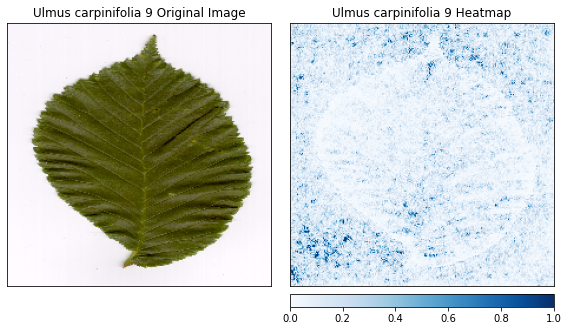

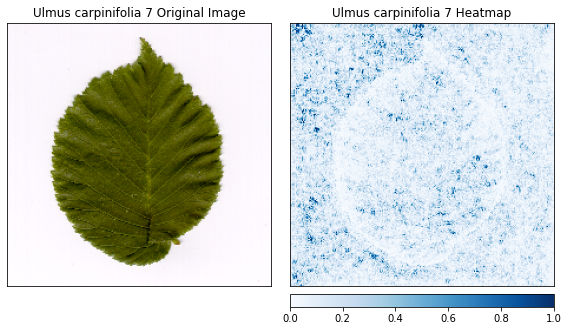

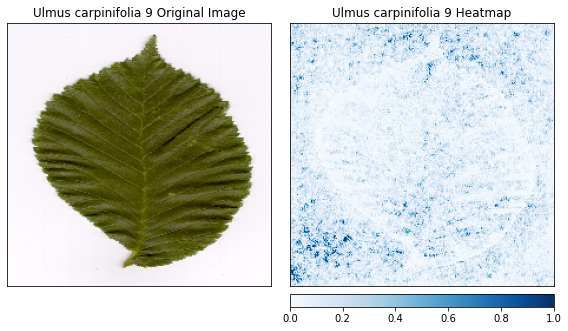

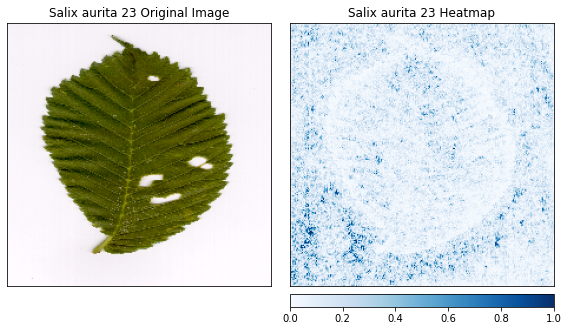

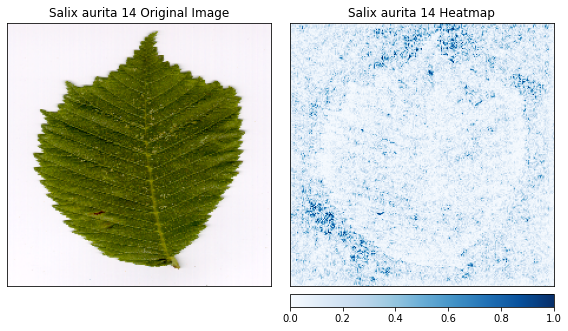

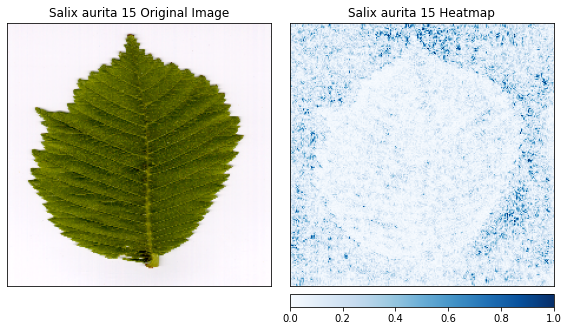

In [29]:
# load model
net = TransferredResNet(freeze=True)
net.load_state_dict(torch.load(os.path.join(MODEL_PATH, f"resnet_freezed_leaves_{LEAF1}_{LEAF2}.pt")))
net.eval()

# choose 6 images from test set (3 from each class) to explain.
random_images_index = np.concatenate([np.random.choice(np.argwhere(
    y_test.reshape(-1,)==label).reshape(-1,), size=3) for label in [0,1]])
images = [X_test[i] for i in random_images_index]
titels = [label_name_dict[y_test[i,0]]['name'] + f" {i}" for i in random_images_index]
plot_gradient_shap_explanation(net, images, titels)

The more a pixel is blue, the more it contributes to a specific class to be classified (either the true class or the wrong one). We can see that the model looks at the pixels corresponding to the leaves' boundaries and inner shape. We can suggest that the model quite ignores the leaves color, for example, as many of the inner pixels in the leaf are white. A suggested step that could be taken after this review is Data Augmentation. It can make the classifier focus more on the leaf itself and not to rely on the location of the leaf within the image.

# Conclusion and Future Work
I used a transfer learning paradigm to propose a model that classify the class of a tree based on its leaf image. This proposed model performed better than a simple ML technique. However, there are more steps that I could have taken for improving this model, some of them are listed below:
* <b>Data Augmentation</b>:
By methods such as flipping, rotating, blurring and color changing I could have gain many more leaf images. Models tend to perform and generalize better when their training data increases, especially if the dataset is super small such as the leaf dataset. There is a danger that the model will learn some features that we know that are not important for classification (as I noted in the end of section 7), and I could have overcome this pitfall by performing data augmentation.
* <b>Hyperparameter Tuning</b>:
Deep learning models have a lot of hyperparameters to play with. Tuning them (by using the training-validation scheme) could extremely improve the model performance. Particularly, when fine tuning a pretrained model I could have set a small learning rate for early layers (that tend to extract low-level general image features) and large one to the new output layer. Moreover, I could have try to fine tune only k late conv layers of the pretrained resnet and assign them different learning rates and so on.
* <b>K-fold Cross Validation</b>:
In such a small dataset, it is not recommended to rely on a specific random split of train-validation sets to fit the net. Instead, I should have implement a k-fold CV method. CV helps estimating the test accuracy better. I didn't implement a CV when training the DL but did use it when training the baseline model. Pytorch doesn't give an "on the shelf" implementation for CV as sklearn does, but if I would want to dive deeper into the hyperparameter tuning and optimization I should have implement it by myself.

# Sources

* [Swedish Leaf Dataset](https://www.cvl.isy.liu.se/en/research/datasets/swedish-leaf/)
* [Stanford cs231n course notes on Transfer Learning](https://cs231n.github.io/transfer-learning/)
* [Pytorch tutorial on Transfer Learning for Computer Vision](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
* [TowardsDataScience Blog: A Comprehensive Hands-on Guide to Transfer Learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)
* [Top 4 Pre-Trained Models for Image Classification with Python Code](https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/)
* [Project on GitHub: Plant-Leaf-Classification-using-Swedish-Leaf-Dataset](https://github.com/Vib-UX/Plant-Leaf-Classification-using-Swedish-Leaf-Dataset)
* [Captum Tutorial: Model Interpretation for Pretrained ResNet Model](https://captum.ai/tutorials/Resnet_TorchVision_Interpret)
* [Integrated Gradients Paper: "Axiomatic Attribution for Deep Networks"](https://arxiv.org/abs/1703.01365)